<a href="https://colab.research.google.com/github/saurabhvybs/AI-RAG-Chatbot/blob/main/AI_Agent_House_of_Shipping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## HOUSE OF SHIPPING AGENT

In [1]:
# Install Python libraries
!pip install selenium beautifulsoup4

# Install the browser and its driver
!apt-get update
!apt-get install -y chromium-browser chromium-chromedriver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 18.2 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,253 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,271 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy I

In [2]:
# Scraper Service
import sys
import json
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# --- Setup for Colab ---
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
# ----------------------

def scrape_website_for_structured_html(start_url: str) -> dict:
    """
    This definitive scraper captures the cleaned HTML structure from the main content
    area of each page, preserving headers for advanced chunking.
    """
    to_visit = {start_url}
    visited = set()
    scraped_data = {}
    base_netloc = urlparse(start_url).netloc
    driver = webdriver.Chrome(options=chrome_options)
    print(f"🚀 Starting structured scrape at: {start_url}")

    while to_visit:
        current_url = to_visit.pop()
        if current_url in visited:
            continue
        try:
            print(f"Scraping: {current_url}")
            driver.get(current_url)
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "body")))

            soup = BeautifulSoup(driver.page_source, 'html.parser')
            visited.add(current_url)

            # Find the main content area to avoid irrelevant headers/footers
            content_area = soup.find('main') if soup.find('main') else soup.find('body')

            # **Crucially, we clean *within* the HTML, keeping header tags intact**
            if content_area:
                for element in content_area(['script', 'style', 'nav', 'footer', 'aside']):
                    element.decompose() # Remove noise, but keep h1, h2, p, etc.

            scraped_data[current_url] = str(content_area) if content_area else ""

            # Crawling logic remains the same
            for link in soup.find_all('a', href=True):
                # ... (rest of link finding logic is unchanged)
                absolute_link = urljoin(current_url, link['href'])
                parsed_link = urlparse(absolute_link)
                if (parsed_link.netloc == base_netloc and
                    parsed_link.scheme in ['http', 'https'] and
                    absolute_link not in visited and
                    "#" not in absolute_link.split('/')[-1]):
                    to_visit.add(absolute_link)
        except Exception as e:
            print(f"Could not process {current_url}: {e}")

    driver.quit()
    print(f"\n Scraping complete. Found {len(scraped_data)} pages.")
    return scraped_data

# --- Main Execution ---
website_url = "https://houseofshipping.com"
structured_content = scrape_website_for_structured_html(website_url)

output_filename = "structured_web_content.json"
with open(output_filename, "w", encoding='utf-8') as f:
    json.dump(structured_content, f, indent=4, ensure_ascii=False)
print(f" Structured HTML content saved to '{output_filename}'")

🚀 Starting structured scrape at: https://houseofshipping.com
Scraping: https://houseofshipping.com
Scraping: https://houseofshipping.com/service/marketing/
Scraping: https://houseofshipping.com/terms-conditions/
Scraping: https://houseofshipping.com/shipping-news-week34-2025/
Scraping: https://houseofshipping.com/category/blog/
Scraping: https://houseofshipping.com/contact/
Scraping: https://houseofshipping.com/service/shared-service-center/
Scraping: https://houseofshipping.com/service/legal-services/
Scraping: https://houseofshipping.com/category/market-updates/
Scraping: https://houseofshipping.com/faq/
Scraping: https://houseofshipping.com/
Scraping: https://houseofshipping.com/service/information-technology/
Scraping: https://houseofshipping.com/service/process-transformation/
Scraping: https://houseofshipping.com/about-us/
Scraping: https://houseofshipping.com/testimonials/
Scraping: https://houseofshipping.com/news-and-insights/
Scraping: https://houseofshipping.com/shipping-new

# EDA (Exploratory Data Analysis) N-gram Analysis

 Successfully loaded 121 structured documents from 'structured_web_content.json'.
--- Analyzing Top 2-Word and 3-Word Phrases ---


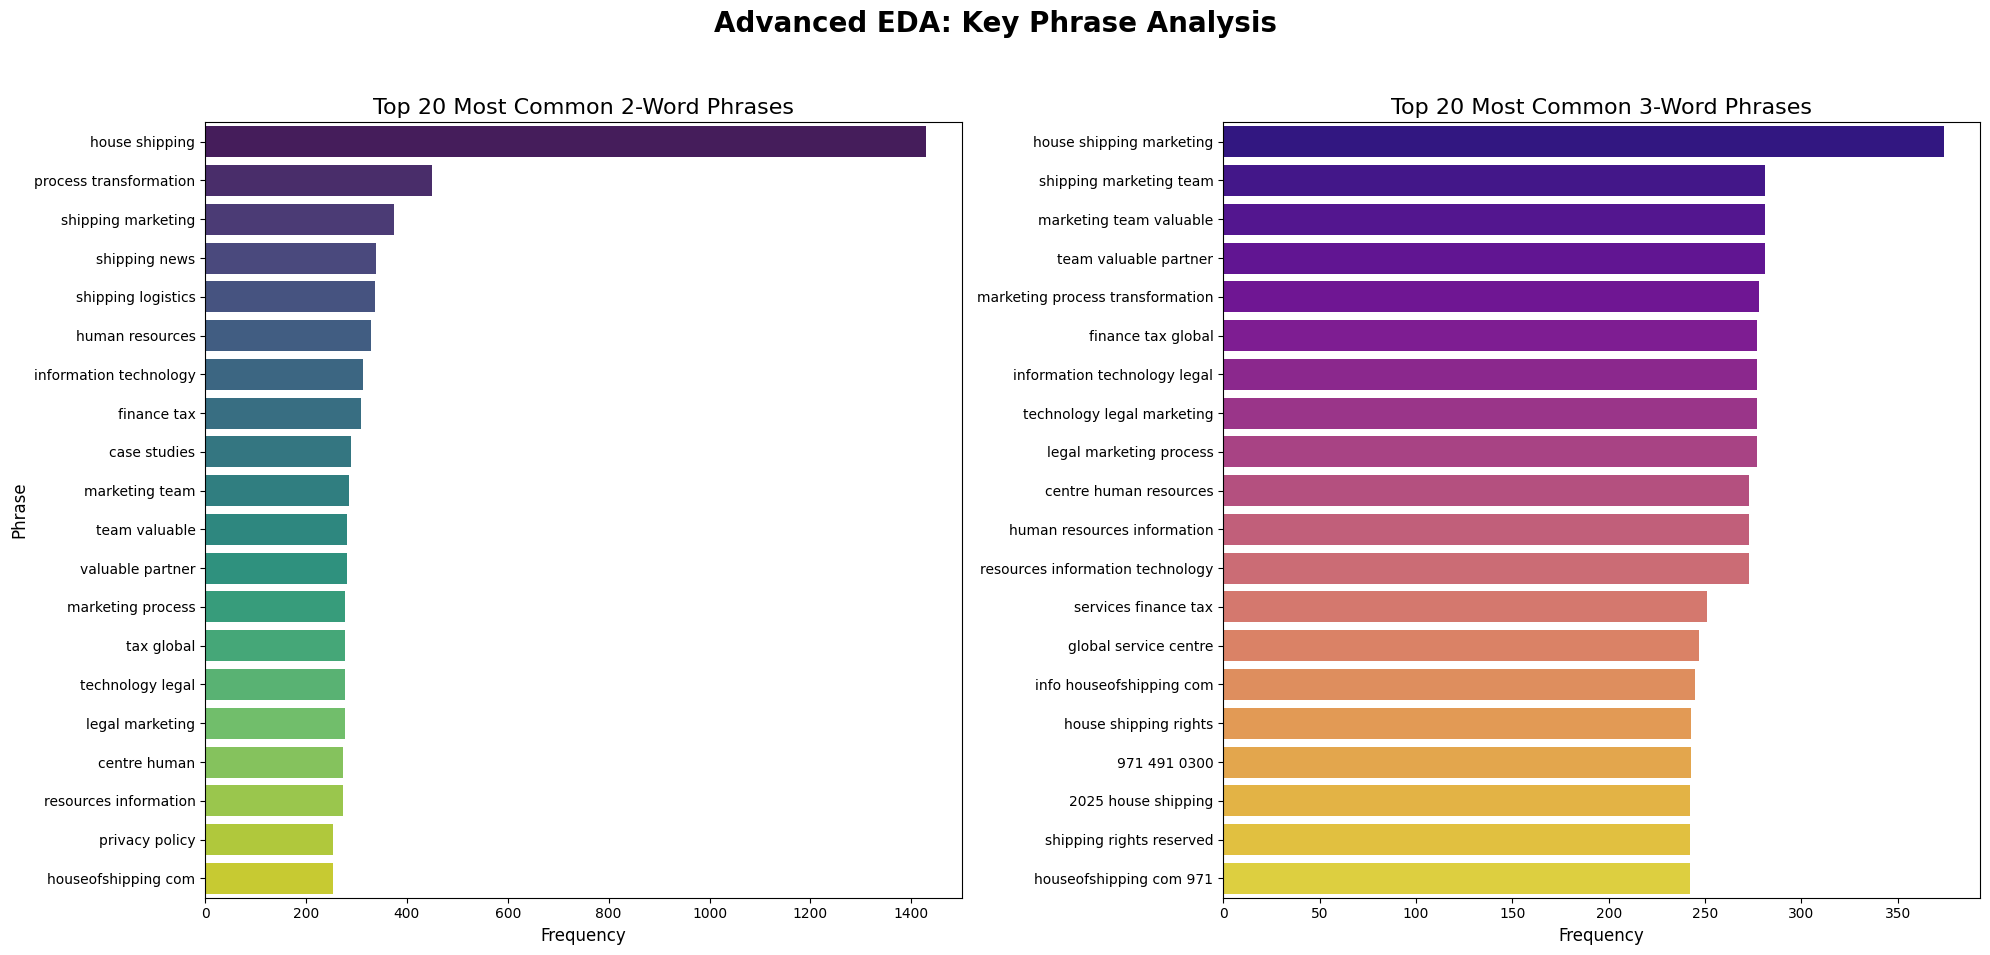

In [3]:
# Load Structured Data & Perform Full EDA
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup

# --- 1. Load the Scraped Data ---
json_file_path = 'structured_web_content.json'
try:
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(list(data.items()), columns=['url', 'raw_html'])
    print(f" Successfully loaded {len(df)} structured documents from '{json_file_path}'.")
except Exception as e:
    print(f" Error: Could not load the file. Please ensure the scraper in Cell 1 has been run successfully. Error: {e}")


# --- 2. For EDA, extract and clean plain text from HTML ---
# This is for analysis only; the raw_html is preserved for chunking.
df['text_for_eda'] = df['raw_html'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text(separator=' ', strip=True).lower())


# --- 3. Advanced EDA: Find and Visualize Top N-grams ---
print("--- Analyzing Top 2-Word and 3-Word Phrases ---")

def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    """Extracts top n-grams from a text corpus."""
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get top 20 bigrams (2-word phrases)
top_bigrams = get_top_ngrams(df['text_for_eda'], n=20, ngram_range=(2, 2))
bigram_df = pd.DataFrame(top_bigrams, columns=['phrase', 'count'])

# Get top 20 trigrams (3-word phrases)
top_trigrams = get_top_ngrams(df['text_for_eda'], n=20, ngram_range=(3, 3))
trigram_df = pd.DataFrame(top_trigrams, columns=['phrase', 'count'])


# --- 4. Visualize the Results ---
plt.figure(figsize=(20, 10))

# Bigrams plot
plt.subplot(1, 2, 1)
sns.barplot(x='count', y='phrase', data=bigram_df, palette='viridis', hue='phrase', legend=False)
plt.title('Top 20 Most Common 2-Word Phrases', fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Phrase", fontsize=12)


# Trigrams plot
plt.subplot(1, 2, 2)
sns.barplot(x='count', y='phrase', data=trigram_df, palette='plasma', hue='phrase', legend=False)
plt.title('Top 20 Most Common 3-Word Phrases', fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("") # Hide y-label for cleaner look

plt.suptitle("Advanced EDA: Key Phrase Analysis", fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# DATA Preparation and Advanced Cleaning

In [4]:
# Structural Chunking and Templating
from langchain.text_splitter import HTMLHeaderTextSplitter, RecursiveCharacterTextSplitter
from bs4 import BeautifulSoup

# 1. Define the primary splitter that understands HTML structure
headers_to_split_on = [
    ("h1", "H1"),
    ("h2", "H2"),
    ("h3", "H3"),
    ("h4", "H4"),
]
html_splitter = HTMLHeaderTextSplitter(headers_to_split_on=headers_to_split_on, return_each_element=False)

# 2. Define a fallback splitter for any large chunks of text without headers
recursive_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)

# 3. Process the data from the DataFrame
all_documents = []
for index, row in df.iterrows():
    # Ensure the content is a string
    if not isinstance(row['raw_html'], str) or not row['raw_html'].strip():
        continue

    # First, try to split by headers.
    header_chunks = html_splitter.split_text(row['raw_html'])

    # Now, iterate through these chunks and split any that are too large
    for chunk in header_chunks:
        # Clean up the text content within the chunk
        chunk_text = BeautifulSoup(chunk.page_content, 'html.parser').get_text(separator=' ', strip=True)

        # Skip chunks with very little actual text
        if len(chunk_text.split()) < 10:
            continue

        if len(chunk_text) > 1000:
            # If a chunk is too big, split it recursively but keep its header metadata
            sub_chunks = recursive_splitter.create_documents([chunk_text])
            for sub_chunk in sub_chunks:
                # Add the original header metadata to the new sub-chunk
                sub_chunk.metadata = chunk.metadata.copy()
                sub_chunk.metadata['source'] = row['url']
                all_documents.append(sub_chunk)
        else:
            # If the chunk is a good size, just update its content and metadata
            chunk.page_content = chunk_text
            chunk.metadata['source'] = row['url']
            all_documents.append(chunk)

print(f" Successfully created {len(all_documents)} structurally-aware documents (chunks).")

# Display a sample chunk to see the result
if all_documents:
    print("\n--- SAMPLE CHUNK ---")
    sample_chunk = all_documents[5] # Using a different index for variety
    print(sample_chunk.page_content)
    print(f"\nMetadata: {sample_chunk.metadata}")

 Successfully created 2578 structurally-aware documents (chunks).

--- SAMPLE CHUNK ---
A full suite of solutions from candidate sourcing to payroll and everything in between.

Metadata: {'H1': 'YOUR DESTINATION FOR SHIPPING AND LOGISTICS CONSULTANCY & ADVISORY SERVICES', 'H2': 'All services under one roof', 'H3': 'A full suite of solutions from candidate sourcing to payroll and everything in between.', 'source': 'https://houseofshipping.com'}


# Vector Knowledge base for RAG.

In [5]:
!pip install langchain langchain-community langchain-huggingface sentence-transformers chromadb -q langchain-chroma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 31.9 MB/s eta 0:

In [6]:
# Cell 4: Build RAG Knowledge Base (Vector Store)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.docstore.document import Document # Included for clarity

print("\n--- Building RAG Knowledge Base ---")

# 1. Load the Embedding Model
# This model will convert your text chunks into numerical vectors.
print("Loading embedding model (this may take a minute)...")
embeddings = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'} # Use CPU for broad compatibility
)
print(" Embedding model loaded.")


# 2. Create the Chroma Vector Store from the documents
# This is the step where your chunks are embedded and stored.
print("Storing chunks in the vector database...")
vector_store = Chroma.from_documents(
    documents=all_documents,
    embedding=embeddings,
    persist_directory="./final_chroma_db"  # This saves the database to a local folder for reuse
)
print(" Vector store created.")


print("\n--- RAG Data Preparation Complete! ---")
print("The 'vector_store' variable now holds your complete, searchable knowledge base.")


--- Building RAG Knowledge Base ---
Loading embedding model (this may take a minute)...


/tmp/ipython-input-3551264680.py:11: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

 Embedding model loaded.
Storing chunks in the vector database...
 Vector store created.

--- RAG Data Preparation Complete! ---
The 'vector_store' variable now holds your complete, searchable knowledge base.


# Adding GEMNI as the Powerful Generalist Model.

In [7]:
!pip install langchain-google-genai -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [8]:
# Setup for Google Gemini
import os
from google.colab import userdata

try:
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
    print(" Google API Key configured successfully.")
except userdata.SecretNotFoundError:
    print(" Error: Secret 'GOOGLE_API_KEY' not found. Please add it to your Colab secrets.")

 Google API Key configured successfully.


# Loading the Knowledge back into the run-time

In [9]:
# Load the Existing Vector Database
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

print("--- Loading the Knowledge Base from Disk ---")

#  Initialize the same embedding model used to create the database
embeddings = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'}
)

# 2. Load the saved vector store from the specified directory
persist_directory = "./final_chroma_db"
vector_store = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

print(" Knowledge Base loaded successfully!")

--- Loading the Knowledge Base from Disk ---
 Knowledge Base loaded successfully!


# Define and Build RAG Engine

## Prompt Stuffing File.

In [10]:
#  Create the Structured JSON Prompt Files
import json

# 1. Define the prompt structure for the history-aware retriever
contextualize_q_prompt_data = [
    ("system", "Given a chat history and the latest user question which might reference context in the chat history, formulate a standalone question which can be understood without the chat history. Do NOT answer the question, just reformulate it if needed and otherwise return it as is."),
    ("placeholder", "{chat_history}"),
    ("human", "{input}"),
]

# 2. Define the prompt structure for the final QA chain
qa_prompt_data = [
    [
        "system",
        "You are an expert assistant for the House of Shipping company. Your tone should be professional and helpful. Answer the user's latest question using both the chat history and the retrieved context.\n\n**Rules:**\n- Synthesize information from both the 'Retrieved Context' and the 'Chat History' to form a complete, conversational answer.\n- If the 'Retrieved Context' does not contain information to answer the latest question, you MUST state: \"I do not have enough information to answer that specific question.\"\n- Do not contradict information that has already been established in the 'Chat History'.\n\n**Retrieved Context:**\n{context}\n"
    ],
    [
        "placeholder",
        "{chat_history}"
    ],
    [
        "human",
        "{input}"
    ]
]

# 3. Write the structures to JSON files
with open("contextualize_prompt.json", "w") as f:
    json.dump(contextualize_q_prompt_data, f, indent=2)

with open("qa_prompt.json", "w") as f:
    json.dump(qa_prompt_data, f, indent=2)

print("✅ Structured prompt files 'contextualize_prompt.json' and 'qa_prompt.json' created.")

✅ Structured prompt files 'contextualize_prompt.json' and 'qa_prompt.json' created.


# History-Aware Retriever

In [11]:
from langchain.memory import ChatMessageHistory

# In a real app, you would have one of these for each user session
chat_history = ChatMessageHistory()

print("✅ Chat history object initialized.")

✅ Chat history object initialized.


In [12]:
from langchain_google_genai import ChatGoogleGenerativeAI

# 1. Create the Retriever from your loaded vector store
retriever = vector_store.as_retriever(search_kwargs={"k": 4})

# 2. Define the Gemini LLM
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

# 3. Define the helper function to format documents
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

print("✅ Retriever, LLM, and helper functions are ready.")

✅ Retriever, LLM, and helper functions are ready.


In [13]:
import json
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser

# Load the structured prompt from its JSON file
with open("contextualize_prompt.json", "r") as f:
    contextualize_q_prompt_data = json.load(f)


# Manually build the list of messages, creating an explicit MessagesPlaceholder object.
messages = []
for role, content in contextualize_q_prompt_data:
    if role == "placeholder":
        # Extract the variable name from inside the curly braces (e.g., "{chat_history}")
        variable_name = content.strip('{}')
        messages.append(MessagesPlaceholder(variable_name=variable_name))
    else:
        messages.append((role, content))

contextualize_q_prompt = ChatPromptTemplate.from_messages(messages)
# --------------------

# Chaining
history_aware_retriever_chain = (
    contextualize_q_prompt
    | llm
    | StrOutputParser()
    | retriever
)

print("✅ History-aware retriever chain created successfully.")

✅ History-aware retriever chain created successfully.


In [14]:
import json
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser

# Load the structured prompt for the final answer from its JSON file
with open("qa_prompt.json", "r") as f:
    qa_prompt_data = json.load(f)

# Manually build the list of messages, creating an explicit MessagesPlaceholder object.
messages = []
for item in qa_prompt_data:
    role, content = item
    if role == "placeholder":
        variable_name = content.strip('{}')
        messages.append(MessagesPlaceholder(variable_name=variable_name))
    else:
        messages.append((role, content))
qa_prompt = ChatPromptTemplate.from_messages(messages)


def retrieve_and_format_context(inputs):
    # First, invoke the history-aware retriever to get the documents
    docs = history_aware_retriever_chain.invoke({
        "input": inputs["input"],
        "chat_history": inputs["chat_history"]
    })
    # Then, format the documents into a single string
    return format_docs(docs)
# --------------------


# Build the final conversational RAG chain using the corrected logic
conversational_rag_chain = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "context": retrieve_and_format_context
    }
    | qa_prompt
    | llm
    | StrOutputParser()
)

print(" Final conversational RAG chain is built and ready for testing.")

 Final conversational RAG chain is built and ready for testing.


# TESTING

In [15]:
#  Comprehensive Testing Script for the RAG Agent
from datetime import datetime

# Define the test suite as a list of test cases
# Each test case has a name, a type, and a sequence of questions (steps)
test_suite = [
    {
        "name": "Fact Retrieval about Services",
        "type": "Knowledge",
        "steps": ["What kind of IT services are offered by House of Shipping?"]
    },
    {
        "name": "Conceptual Question from Insights",
        "type": "Knowledge",
        "steps": ["Based on your articles, what is the importance of digital transformation for the shipping industry?"]
    },
    {
        "name": "Rule-Following - Out of Scope Question",
        "type": "Rule-Following",
        "steps": [f"What is the current time in Lucknow? It is currently {datetime.now().strftime('%I:%M:%S %p')}."]
    },
    {
        "name": "Conversational Memory - Simple Follow-up",
        "type": "Memory",
        "steps": [
            "How did House of Shipping assist WeFreight with their expansion?",
            "What was the direct result of that assistance?"
        ]
    },
    {
        "name": "Conversational Memory - Topic Change",
        "type": "Memory",
        "steps": [
            "Tell me about the company's legal services.",
            "Does that also include any marketing services?"
        ]
    },
    {
        "name": "Rule-Following - Plausible but Unavailable Detail",
        "type": "Rule-Following",
        "steps": ["Can you give me the direct phone number for the Global CEO, Alessandra Ronco?"]
    }
]

# --- Test Runner ---
print(" STARTING COMPREHENSIVE AGENT TEST SUITE 🚀")
print("="*50)

for i, test in enumerate(test_suite):
    print(f"\n EXECUTING TEST {i+1}: {test['name']} ({test['type']})")
    print("-"*40)

    # Initialize a fresh, independent chat history for each test case
    test_chat_history = ChatMessageHistory()

    # Loop through the steps (questions) for the current test
    for step, question in enumerate(test['steps']):
        print(f"\nStep {step + 1} of {len(test['steps'])}")
        print(f" You: {question}")

        # Invoke the conversational chain with the current question and the test's history
        answer = conversational_rag_chain.invoke({
            "input": question,
            "chat_history": test_chat_history.messages
        })

        print(f"\n🤖 AI: {answer}")

        # Update the test's chat history for the next step
        test_chat_history.add_user_message(question)
        test_chat_history.add_ai_message(answer)

    print("\n" + "="*50)

print("\n TEST SUITE COMPLETE .... Shakalaka BOOM BOOM")

 STARTING COMPREHENSIVE AGENT TEST SUITE 🚀

 EXECUTING TEST 1: Fact Retrieval about Services (Knowledge)
----------------------------------------

Step 1 of 1
 You: What kind of IT services are offered by House of Shipping?

🤖 AI: I do not have enough information to answer that specific question.  The provided text only describes House of Shipping's HR services and mentions data collection from their websites, but it doesn't detail any IT services offered.


 EXECUTING TEST 2: Conceptual Question from Insights (Knowledge)
----------------------------------------

Step 1 of 1
 You: Based on your articles, what is the importance of digital transformation for the shipping industry?

🤖 AI: Based on the provided text, digital transformation is crucial for the shipping industry for several key reasons:

* **Cost Efficiency:** Automating tasks and optimizing processes leads to significant cost reductions.
* **Speed and Accuracy:** Automation and data-driven insights result in faster and more 

## Now Improve the Prompt Rules for Handling User more Efficiently.

## And If needed simply Ingest more DATA to it and keep the Agent Up-to Date or simply add cron jobs to scrape the site after specific time Interval.